The simulator will be defined as $X = \theta^2 + \text{Gaussian noise}$, with $\theta$ having a uniform prior from 0 to 1. We'll aim to compute the posterior given a true observation $x=0.5$.

### Step 1: Define the Simulator and Prior

First, we define the simulator function and the prior distribution for $\theta$.

In [1]:
import torch
from torch.distributions import Uniform, Normal

# Define the simulator
def simulator(theta):
    noise = Normal(0, 0.1).sample(theta.shape)  # Gaussian noise with std dev of 0.1
    return theta**2 + noise

# Define the prior
prior = Uniform(-1, 1)

### Step 2: Generate Observations for Training

To train the flow-based model, we need to generate observations from the simulator under different parameter values sampled from the prior.

In [2]:
def generate_observations(prior, simulator, num_samples=1000):
    thetas = prior.sample((num_samples,))
    xs = simulator(thetas)
    return thetas, xs

# Assuming thetas and xs are generated as before
thetas, xs = generate_observations(prior, simulator)

# Ensure thetas and xs have a batch dimension
# If they don't, you can add one using unsqueeze
# For example, if thetas is of shape (1000,), make it (1000, 1) to add a feature dimension
thetas = thetas.unsqueeze(-1)
xs = xs.unsqueeze(-1)

### Step 3: Define and Train the Flow-Based Model

We'll use a simple normalizing flow model for this example. The training process involves learning to transform the prior distribution into the posterior distribution given the observations.

In [6]:
from lampe.inference import FMPE, FMPELoss
from torch.optim import Adam

# Define the flow-based model for posterior estimation
estimator = FMPE(theta_dim=1, x_dim=1, hidden_features=[64] * 5, activation=lambda: torch.nn.ELU())

# Define the loss and optimizer
loss_fn = FMPELoss(estimator)
optimizer = Adam(estimator.parameters(), lr=1e-3)

# Now, let's try a single forward pass through the model to check if the dimensions align
try:
    loss = loss_fn(thetas, xs)
    print("Single forward pass successful. Loss:", loss.item())
except RuntimeError as e:
    print("Error during forward pass:", e)

# If the above test is successful, you can proceed with the training loop as before

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_fn(thetas, xs)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Single forward pass successful. Loss: 1.2653210163116455
Epoch 0, Loss: 1.2580422163009644
Epoch 10, Loss: 1.1641621589660645
Epoch 20, Loss: 1.1868393421173096
Epoch 30, Loss: 1.115138292312622
Epoch 40, Loss: 1.127582311630249
Epoch 50, Loss: 0.8965844511985779
Epoch 60, Loss: 0.9506657123565674
Epoch 70, Loss: 0.9134315252304077
Epoch 80, Loss: 0.8870276212692261
Epoch 90, Loss: 0.9471795558929443
Epoch 100, Loss: 0.8571058511734009
Epoch 110, Loss: 0.857761561870575
Epoch 120, Loss: 0.867291271686554
Epoch 130, Loss: 0.8865364193916321
Epoch 140, Loss: 0.8117932677268982
Epoch 150, Loss: 0.8566018342971802
Epoch 160, Loss: 0.8039844036102295
Epoch 170, Loss: 0.8074038028717041
Epoch 180, Loss: 0.8322719931602478
Epoch 190, Loss: 0.729475200176239
Epoch 200, Loss: 0.76966792345047
Epoch 210, Loss: 0.8682664036750793
Epoch 220, Loss: 0.8607759475708008
Epoch 230, Loss: 0.8109410405158997
Epoch 240, Loss: 0.7638052701950073
Epoch 250, Loss: 0.7094686031341553
Epoch 260, Loss: 0.751494

### Step 4: Compute the Posterior for the True Observation $x=0.5$

After training the model, we can use it to estimate the posterior distribution for the true observation $x=0.5$.

In [7]:
true_observation = torch.tensor([[0.5]])

# Evaluate the model to get the posterior distribution
estimator.eval()
with torch.no_grad():
    posterior = estimator.flow(true_observation)

# Sample from the posterior
posterior_samples = posterior.sample((1000,))

### Visualization


Finally, we visualize the posterior samples similar to the `fmpe.ipynb` tutorial.

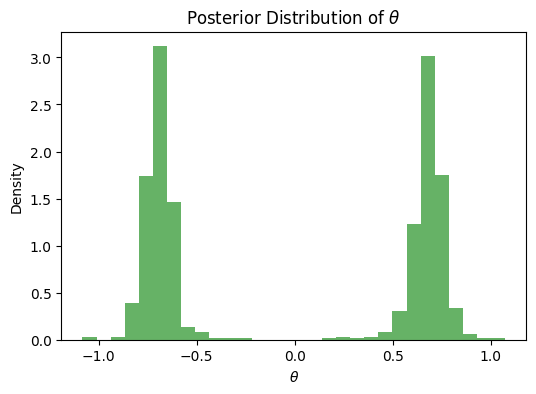

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming posterior_samples is a tensor of shape (1000, 1) containing samples from the posterior
samples = posterior_samples.numpy().flatten()  # Flatten to ensure it's 1D

# Visualization settings
plt.figure(figsize=(6, 4))
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
plt.title('Posterior Distribution of $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('Density')
plt.show()

This process demonstrates how to use simulation-based inference with flow matching to estimate the posterior distribution of a parameter given an observation. The key steps include defining a simulator, generating observations, training a flow-based model, and finally, using the model to estimate the posterior distribution for a given true observation, followed by visualizing the posterior samples.